## Homework on Modern Convolutional Neural Networks


### Description

In this homework, you need to write a convolutional neural network for image classification.

You have been provided with a modified dataset of The Street View House Numbers ([SVHN](http://ufldl.stanford.edu/housenumbers/)). It contains 50 thousand (train) + 25 thousand (test) 32x32 RGB images with numbers cut from real photos of house numbers.

Task: use convolutional neural networks to achieve maximum classification accuracy.

In this homework task, there are no restrictions on the architecture of the model, but you **need to implement it in PyTorch by yourself** and train it from scratch only on this dataset, without external data.

### Data

This notebook already has the code for PyTorch responsible for loading the data. The following is a brief description of the data storage format.

Each of the files is a `pickle` serialized with protocol version 4 (which became the default version in Python 3.8 and later) a python dictionary.

List of files:

- `meta` - dataset metadata (for example, class names)
- `data_train` - training data, 50K objects
- `data_test` - data for the test, 25K objects, without the correct classes

Data dictionaries have the following fields:

- `section` — name of the data part (train/test)
- `labels` - ground-truth classes, list of `N` numbers from 0 to 9
- `images` - numpy array of size `(N, 32, 32, 3)` with images

### Grade

The quality of the solution will be evaluated by the metric accuracy. Accuracy is the number of correctly classified pictures to the total number of pictures in the test set. The public leaderboard is calculated using 30% of the test data, so try not to retrain for it.

```
accuracy = (correct classified) / (total number of examples)
```

As a solution, you should send a file of the format:

```
ID,Category
0, 3
1, 2
2, 9
3, 1
...
```

where:

- `Id` — number of the object in the test dataset
- `Category` — predicted object class

This notebook already has the code that prepares the solution file.

### Experiments

Since there are so many different hyperparameters in training a neural network model, many different experiments will need to be done in this task. And it will be very useful, both for you and for us, who check, the presence of a text description of all, or at least the most interesting/important in choosing the final model, experiments with the results in the final notebook. The presence and detail of the description of the experiments will be included in the final grade for the homework. The deadline on Kaggle is specially set a little earlier so that you have time to calmly finish the report on the experiments.

## Baseline solution

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output

In [3]:
import os
import pickle
from typing import Any, Callable, Optional, Tuple
from PIL import Image

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Compose
from torchvision.datasets.vision import VisionDataset

The data is in the [Data](https://www.kaggle.com/c/sirius-spbsu-2022-entry-competition/data) section of the kaggle competition. <br>
You need to download the archive with the data and unzip it. <br>
In the variable below, specify the path to the dataset. <br>

In [5]:
dataset_root = "data/"

Code for loading the modified SVHN dataset. Initialization Arguments:

- `root` — string, path to directory with dataset files
- `is_train` — flag, load part for training or test
- `transform` — image transformations
- `target_transform` — image class transformations

In [6]:
class SVHN(VisionDataset):

    def __init__(self,
                 root: str,
                 is_train: bool = True,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,
                 ) -> None:

        super().__init__(root, transform=transform, target_transform=target_transform)
        self.is_train = is_train

        meta_path = os.path.join(self.root, 'meta')
        with open(meta_path, "rb") as f:
            content = pickle.load(f)
            self.classes = content['label_names']
            self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

        data_path = os.path.join(self.root, 'data_train' if is_train else 'data_test')
        with open(data_path, "rb") as f:
            content = pickle.load(f)
            self.data = content['images']
            self.targets = content.get('labels')

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img = Image.fromarray(self.data[index].astype(np.uint8))
        target = self.targets[index] if self.is_train else len(self.classes)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def __len__(self) -> int:
        return len(self.data)
        
    def extra_repr(self) -> str:
        split = "Train" if self.train is True else "Test"
        return f"Split: {split}"

### Dataset download

In [7]:
data = SVHN(
    root=dataset_root,
    is_train=True,
    transform=ToTensor(),
)

We randomly split the dataset into training and validation. <br>
In the first part, we will train the classification model. <br>
In the second part, we will evaluate the quality during the experiments. <br>

In [8]:
train_data, val_data = torch.utils.data.random_split(
    data, 
    [40000, 10000], 
    generator=torch.Generator().manual_seed(137),
)

Data loaders initialization.

In [9]:
batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

Let's see what size batches the data loader produces.

In [11]:
for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 3, 32, 32])
Shape of y:  torch.Size([64]) torch.uint8


### Classification model

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


We set the architecture of the classification model. <br>
There is a lot of room for different experiments. <br>

In [13]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*32*32, 10),
)

We send the model to the selected device.

In [14]:
model = model.to(device)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=10, bias=True)
)


### Training

We set the loss function (optimization goal) and the optimizer.

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Code for visualizing the learning process.

Every `interval` optimization steps and at the end of epochs, we write the values of the loss function and metrics to the log. <br>
Then, by calling the `show_progress` function, we update the training schedule. <br>

In [16]:
# Training logs
interval = 100
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

In [17]:
def show_progress(t):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 5))
    fig.suptitle(f'Epoch {t:3.3f}', fontsize=16)
    ax1.set_title('loss')
    ax1.set_xlabel('time (epochs)')
    ax1.set_ylabel('loss')
    ax1.plot(train_ts, train_loss, c='darkblue', lw=3)
    ax1.plot(val_ts, val_loss, c='green', marker='o', lw=5)
    ax2.set_title('accuracy')
    ax2.set_xlabel('time (epochs)')
    ax2.plot(val_ts, val_acc, c='green', marker='o', lw=5)
    plt.show() 

In [18]:
def train(epoch, dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Send data to training device
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Progress output
        if batch % interval == 0:
            t = epoch + (batch + 1)/num_batches
            train_ts.append(t)
            train_loss.append(loss.item())
            show_progress(t)

In [19]:
def test(epoch, dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    val_ts.append(epoch+1)
    val_loss.append(test_loss)
    val_acc.append(correct)
    show_progress(epoch+1)

Training loop.

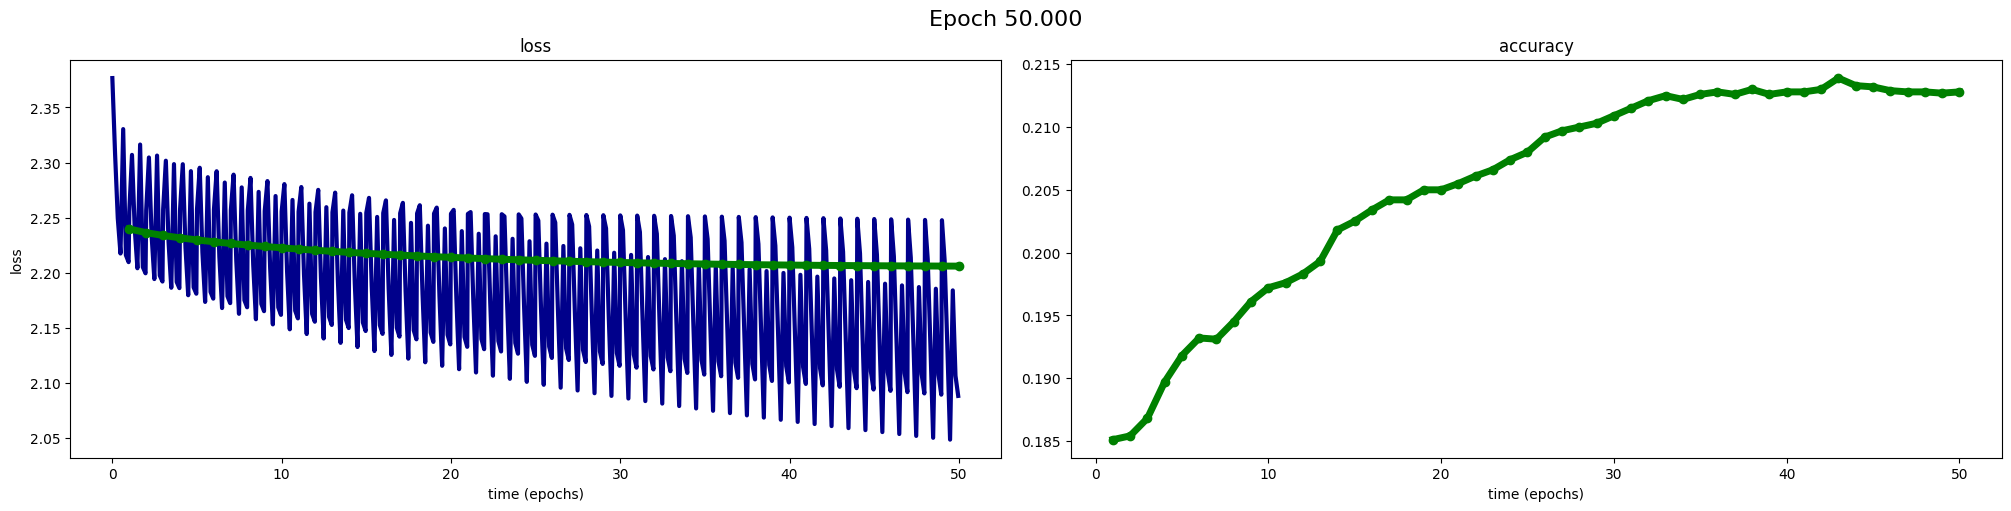

100%|███████████████████████████████████████████████████████████████████████████████████████| 50/50 [07:48<00:00,  9.37s/it]


In [20]:
epochs = 50
for t in trange(epochs):
    train(t, train_dataloader, model, loss_fn, optimizer)
    test(t, val_dataloader, model, loss_fn)

### Submit solution

Download the test part of the dataset.

In [21]:
test_data = SVHN(
    root=dataset_root,
    is_train=False,
    transform=ToTensor(),
)

In [22]:
test_dataloader = DataLoader(
    test_data, 
    batch_size=batch_size,
)

We make predictions by the final model.

In [23]:
predictions = []

model.eval()
with torch.no_grad():
    for X, _ in test_dataloader:
        X = X.to(device)
        pred = model(X).argmax(1).cpu().numpy()
        predictions.extend(list(pred))

We form a solution file to submit to Kaggle.

In [24]:
def write_solution(filename, labels):
    with open(filename, 'w') as solution:
        print('Id,Category', file=solution)
        for i, label in enumerate(labels):
            print(f'{i},{label}', file=solution)
            
write_solution('solution.csv', predictions)